In [1]:
import spacy
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
from pyfonts import load_bunny_font

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-12-30/christmas_novel_text.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114134 entries, 0 to 114133
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   gutenberg_id  114134 non-null  int64 
 1   text          89245 non-null   object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [4]:
df

,gutenberg_id,text
0,46,A CHRISTMAS CAROL
1,46,NaN
2,46,IN PROSE
3,46,BEING
4,46,A Ghost Story of Christmas
...,...,...
114129,52935,think the givers found it more blessed than th...
114130,52935,Mr. Blake heard in his rounds I cannot tell. I...
114131,52935,must ask the Old Ebony.
114132,52935,NaN


In [5]:
# Load English tokenizer
nlp = spacy.load("en_core_web_sm")

In [6]:
# Convert text column to string, drop missing values
df["text"]= df["text"].astype(str)
text = df['text'].dropna()

# List to store pairs
adjective_xmas_pairs = []

# Function to process text and find adjective + christmas pairs 
def find_pairs(text):
    # Process the text with spacy
    doc = nlp(text)
    
    # Iterate through tokens from 1 to avoid out of range for i-1
    for i in range(1, len(doc)):  
        # If token is "christmas" and the previous token is an adjective with length longer than 1
        if doc[i].text.lower() == "christmas" and doc[i-1].pos_ == "ADJ" and len(doc[i-1].text) > 1:
            # Add to the list
            adjective_xmas_pairs.append((doc[i-1].text, doc[i].text))

In [7]:
%%time
# Apply the function 
df["text"].apply(find_pairs)

CPU times: user 30min 58s, sys: 29.2 s, total: 31min 27s
Wall time: 31min 31s


0         None
1         None
2         None
3         None
4         None
          ... 
114129    None
114130    None
114131    None
114132    None
114133    None
Name: text, Length: 114134, dtype: object

In [8]:
# Convert adjectives to lowercase and christmas to Christmas
lowercase_data = [(x[0].lower(), x[1].title()) for x in adjective_xmas_pairs]

# Count the pairs
counter = Counter(lowercase_data)

# Convert the counter into a df
df = pd.DataFrame(counter.items(), columns=["pair", "count"])

In [9]:
# Sort values by count in descending order
df = df.sort_values(by="count", ascending=False, ignore_index=True)

In [10]:
# Load font
font = load_bunny_font("ABeeZee")

Networkx [edge colormap](https://networkx.org/documentation/stable/auto_examples/drawing/plot_edge_colormap.html)

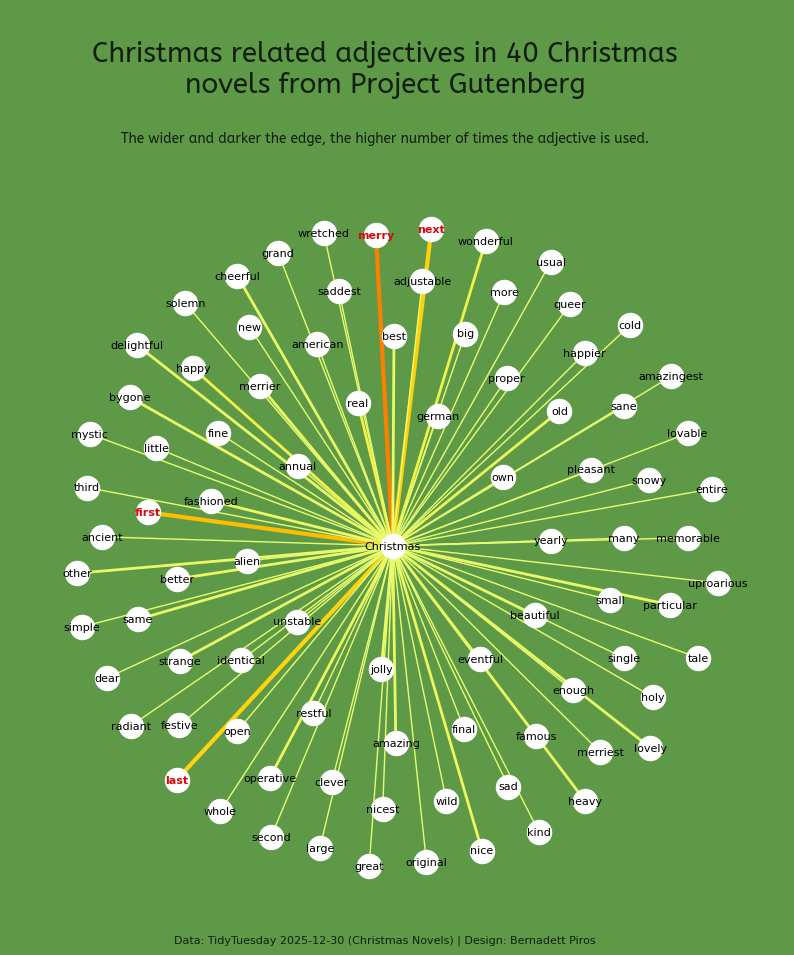

In [11]:
# Create a graph
G = nx.Graph()

# Add nodes and edges 
for word1, word2 in lowercase_data:
    G.add_node(word1)
    G.add_node(word2)
    G.add_edge(word1, word2)

# Node positions
pos = nx.spring_layout(G, seed=42)

# Edge color mapping based on the "count" column 
edge_colors = []
edge_widths = []

for u, v in G.edges():
    # Find the pair and count
    pair = (u, v) if (u, v) in counter else (v, u)  # Make sure that order doesn't matter
    count = counter[pair]  
    
    # Edge color based on count 
    color = plt.cm.Wistia(count / max(counter.values()))  # Normalize count for colormap
    edge_colors.append(color)
    
    # Edge width based on count
    if count > 10:
        edge_widths.append(3)
    elif 2 <= count <= 9:
        edge_widths.append(2)
    else:
        edge_widths.append(1)

# Filter rows where "count" > 10
filtered_df = df[df["count"] > 10].copy()

# Extract word1 (adjective) from the "pair" column
filtered_df["word1"] = filtered_df["pair"].apply(lambda x: x[0])

# Convert adjectives into a list
label_list = filtered_df["word1"].tolist()

# Custom font properties
font_weights = {label: "bold" if label in label_list else "normal" for label in G.nodes()}
font_colors = {label: "#D60910" if label in label_list else "black" for label in G.nodes()}

# Options 
options = {
    "node_color": "white",  
    "edge_color": edge_colors,  
    "width": edge_widths,  
    "with_labels": True,
    "font_size": 8,  
    "font_weight": font_weights,  
    "font_color": font_colors,  
}

fig, ax = plt.subplots(figsize=(10, 10))

# Draw the graph
nx.draw(G, pos, **options, ax=ax)

fig.set_facecolor("#5E9948")

# Add title
fig.text(0.5, 0.95, "\nChristmas related adjectives in 40 Christmas\nnovels from Project Gutenberg", size=20, alpha=0.8, font=font, ha="center")

fig.text(0.5, 0.9, "The wider and darker the edge, the higher number of times the adjective is used.", size=10, alpha=0.8, font=font, ha="center")

# Add caption
fig.text(0.5, 0.1, "Data: TidyTuesday 2025-12-30 (Christmas Novels) | Design: Bernadett Piros", size=8, alpha=0.8, ha="center")

# Show the plot
plt.show()

#fig.savefig("2025-12-30.png", bbox_inches="tight", pad_inches=0.2)